# Experiment XAI

Primer de tot descarregam les dades. Aquestes dades els hem obtingut del dataset [MURA](https://stanfordmlgroup.github.io/competitions/mura/), una vegada que ho hem obtingut les hem organitzades seguint la forma per defecte del ``ImageDataGenerator`` de la llibreria Keras. 

Descarregam les dades i **descomprimim** les dades.

In [198]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
if False:
    !wget https://www.dropbox.com/s/r0wrxxvpvffwx1w/mura.zip?dl=1 -O mura.zip
    !unzip mura.zip

## Importam les llibraries

In [128]:
import itertools

import cv2
import tqdm
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from skimage import transform
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as k_applications
import tensorflow.keras.models as keras_model
import tensorflow.keras.layers as keras_layer
from tensorflow.keras.optimizers import *

import lime
from lime import lime_image

## Generadors de dades

In [98]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagent = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/MURA/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode='rgb',
        batch_size=5,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

val_generator = val_datagent.flow_from_directory(
        'data/MURA/valid',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode='rgb',
        batch_size=5,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 35523 images belonging to 7 classes.
Found 3008 images belonging to 7 classes.


# Model

Empram un model de l'estat de l'art, una **ResNet101** (veure [*Deep Residual Learning for Image Recognition* ](https://arxiv.org/abs/1512.03385)). De l'arquitectura original eliminam les capes denses i afegim les nostres pròpies. **No feim *transfer learning***.

In [ ]:
model = k_applications.ResNet101(include_top=False, input_tensor=keras_layer.Input((224, 224, 3)))

x = keras_layer.Flatten()(model.layers[-1].output)
x = keras_layer.Dense(1024)(x)
x = keras_layer.Dense(1024)(x)
x = keras_layer.Dense(1024)(x)

x = keras_layer.Dense(7, activation='softmax')(x)

model = keras_model.Model(inputs=model.input, outputs=x)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

model.summary()

## Entrenam el model

Una vegada que tenim definit el model i les dades preparades entrenam el model. L'entrenam amb 50 èpoques.

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, validation_steps=10, epochs=50)

Una vegada entrenat mostram els gràfics de les pèrdua i l'accuracy per època per poder obervar el procés d'entrenament. Per altra part,  mostrarem, la matriu de confusió i un conjunt de mètriques de classificació per poder coneixer la qualitat de les prediccions.

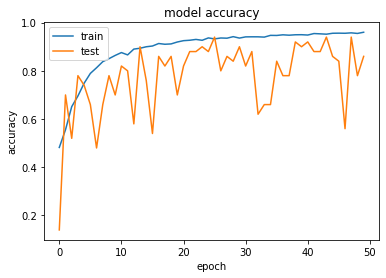

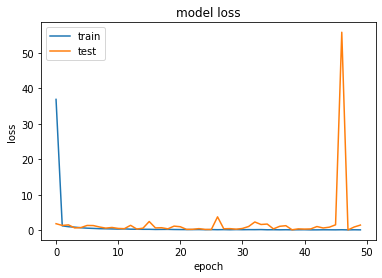

In [10]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
predictions = []
gt = []

for i in tqdm.tqdm(range(602)):
    predictions.append(model.predict(val_generator[i][0]))
    gt.append(val_generator[i][1])
    
predictions = np.array(list(itertools.chain.from_iterable(predictions)))
gt = np.array(list(itertools.chain.from_iterable(gt)))
predictions = np.argmax(predictions, axis = 1)
gt = np.argmax(gt, axis = 1)

100%|██████████| 602/602 [00:51<00:00, 11.62it/s]


Obtenim les mètriques tipiques de classificació per classe. A més mostram la matriu de confusió.

In [135]:
print(metrics.classification_report(y_true=gt, y_pred=predictions, target_names=["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"]))

              precision    recall  f1-score   support

       ELBOW       0.88      0.80      0.84       451
      FINGER       0.98      0.84      0.90       440
     FOREARM       0.71      0.74      0.73       293
        HAND       0.87      0.94      0.90       438
     HUMERUS       0.82      0.80      0.81       283
    SHOULDER       0.85      0.92      0.88       512
       WRIST       0.92      0.94      0.93       591

    accuracy                           0.87      3008
   macro avg       0.86      0.86      0.86      3008
weighted avg       0.87      0.87      0.87      3008



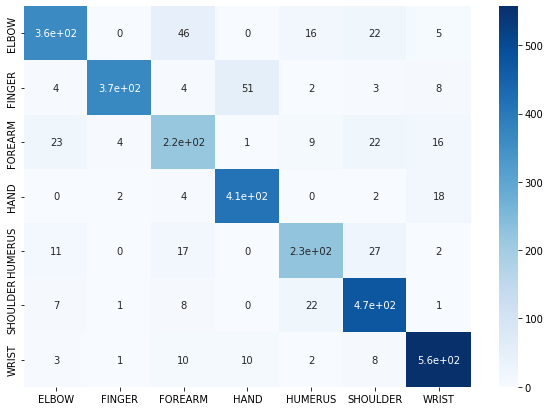

In [196]:
confusion_matrix = metrics.confusion_matrix(y_true=gt, y_pred=predictions)  # shape=(12, 12)
df_cm = pd.DataFrame(confusion_matrix, index = ["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"],
                  columns = ["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues");

Podem observar que les pitjors classes són l'avantbraç (*forearm*). Així i tot podem veure que hi ha relativament poca confussió entre les classes.

# XAI

Una vegada que tenim un model entrenat podem aplicar-hi tècniques de XAI. Primerament aplicarem la tècnica [LIME](https://arxiv.org/abs/1606.05386). Aquesta tècnica permet obtenir un conjunt diferent de visualitzacions però internament és una única explicació.

In [13]:
explainer = lime_image.LimeImageExplainer()

Primerament llegim una imatge que emprarem per trobar la seva explicació. S'ha de tenir en compte que la xarxa està entrenada amb imatges de 244px per 244px, per tant deformam la imatge. Si ens interessas evitar aquesta deformació el que podriem fer és afegir píxels negres per evitar la deformació. 

Un altre element a tenir en compte és que li passam imatges de tres canals, diria que podriem passar imatges monocanals sense perdre informació.

**Explicació LIME**: LIME, en aquest context, és un algorismes que consisteix en tres part, una primera que agrupa els píxels en superpíxels; una segona que amaga una part d'aquests superpíxels per fer tests d'oclussió i una tercera que entrena un classificador líneal per prediure el canvis entre classe produïts per aquesta oclussió.

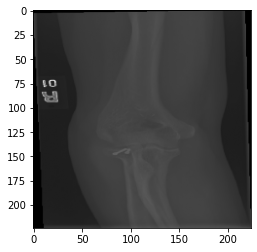

In [183]:
image = cv2.imread("./data/MURA/valid/ELBOW/11186_1.png")
image = skimage.transform.resize(image, (224, 224, 3))

plt.imshow(image)
plt.show()

Una vegada que tenim la imatges miram quina és la predicció que obté el model.

In [175]:
pred = model.predict(image.reshape(1, 224, 224, 3))
names = np.array(["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"])

for name, v in zip(names[np.argsort(pred)[0][::-1]], sorted(pred[0][::-1], reverse=True)):
    print(f"Classe {name}, probabilitat {v}")

Classe ELBOW, probabilitat 0.9911903142929077
Classe FOREARM, probabilitat 0.008522527292370796
Classe HUMERUS, probabilitat 0.00028492193087004125
Classe WRIST, probabilitat 1.0825890512933256e-06
Classe SHOULDER, probabilitat 1.0711966069720802e-06
Classe FINGER, probabilitat 4.4300890067461296e-08
Classe HAND, probabilitat 1.8492410935877501e-09


Podem veure que fa una predicció correcte, predint la classe colze, i que la segona amb molta distància és l'avantbraç.
 
Una vegada que sabem la predicció que obté el model empram LIME per obtenir l'explicació. Farem diferents visualitzacions de la mateixa explicació. 

In [142]:
explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Explicació classificació amb major probabilitat: colze

### Superpíxels amb un pes major que 10% positiu

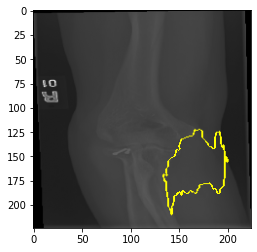

In [162]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Superpíxels amb un pes major que 10% positiu (eliminam la resta de la imatge).

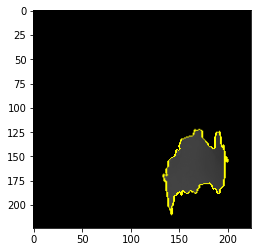

In [157]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=True, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Superpíxels amb un pes major que 10% tant positiu com negatiu. 

Verd -> Positiu.

Vermell -> Negatiu.

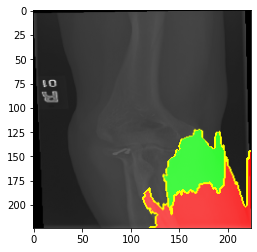

In [156]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Cinc superpíxels amb més pes. 

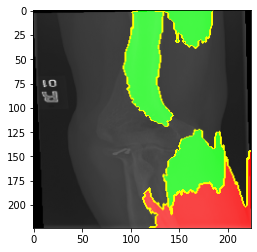

In [159]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

### Tots els superpíxels, tant positius com negatius

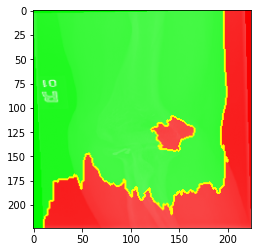

In [181]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

### Mapa de color amb tots els superpíxels

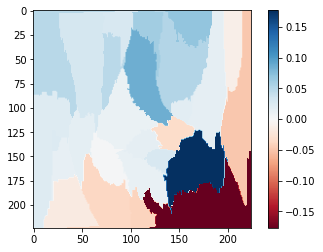

In [160]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();

Les explicacions, semblen indicar que un dels elements més importants és l'articulació i el seu entorn i també sembla que quan més ens allunyam de la articulació (especialment part inferior de la imatge) més negativament afecta a la predicció.

## Explicació segona millor classificació: avantbraç

Una altre cosa que podem fer és obtenir una explicació per la segona classes amb més probabilitats. 

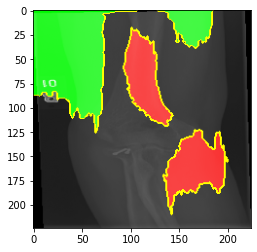

In [180]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

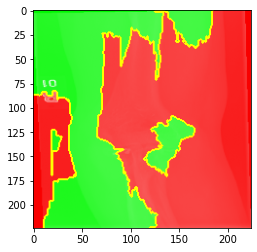

In [182]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=50, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

Podem observar un detall interessant d'aquesta explicació: els valors negatius (de la classificació incorrecte) s'obtenen a prop de l'articulació.

## Segona imatge

Farem el mateix procés amb una altre imatge d'una altre classe. En aquest cas farem un avantbraç.

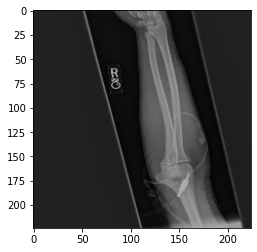

In [184]:
image = cv2.imread("./data/MURA/valid/FOREARM/11188_1.png")
image = skimage.transform.resize(image, (224, 224, 3))

plt.imshow(image)
plt.show()

In [185]:
pred = model.predict(image.reshape(1, 224, 224, 3))
names = np.array(["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"])

for name, v in zip(names[np.argsort(pred)[0][::-1]], sorted(pred[0][::-1], reverse=True)):
    print(f"Classe {name}, probabilitat {v}")

Classe FOREARM, probabilitat 0.9842756986618042
Classe WRIST, probabilitat 0.015709245577454567
Classe ELBOW, probabilitat 1.0285841199220158e-05
Classe FINGER, probabilitat 3.4203103496111e-06
Classe SHOULDER, probabilitat 6.520092483697226e-07
Classe HUMERUS, probabilitat 6.124072911006806e-07
Classe HAND, probabilitat 5.779330347621681e-09


Podem observar que la classificació torna a ser correcte. Podem observar, tot seguit les explicacions.

In [186]:
explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Explicació classificació amb major probabilitat: avantbraç

### Superpíxels amb un pes major que 10% positiu

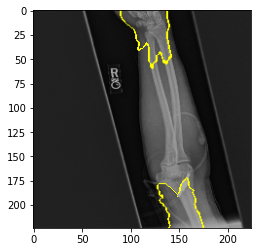

In [189]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Superpíxels amb un pes major que 10% positiu (eliminam la resta de la imatge).

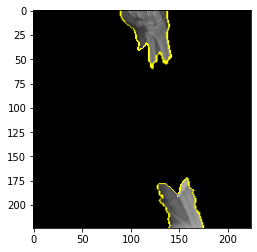

In [190]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=True, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Superpíxels amb un pes major que 10% tant positiu com negatiu. 

Verd -> Positiu.

Vermell -> Negatiu.

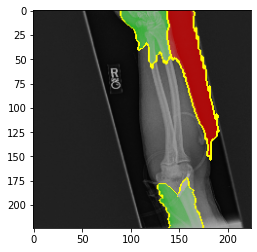

In [191]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

### Cinc superpíxels amb més pes. 

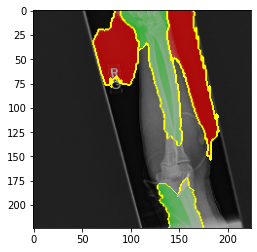

In [192]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

### Tots els superpíxels, tant positius com negatius

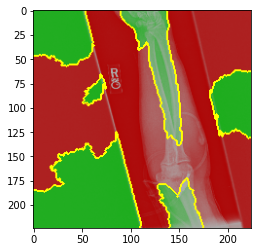

In [193]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

### Mapa de color amb tots els superpíxels

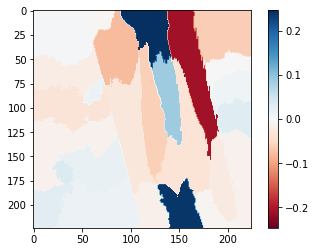

In [194]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();

Les explicacions semblen tenir sentit, ja que sembla que té en compte, el cúbit i el radi, a part d'una metainformació com és l'espai negre dels costats (típicament les radiografies d'avantbraç són més allargades i estan enrevoltades de píxels negres).